# Object-Level Analysis for 1 Perturbation Dimension

This notebook analyzes how individual classified objects perform across different wavelength band selections in the 1-Dimension perturbation case.

## Objectives
1. Track individual object accuracy across different band counts
2. Identify objects that are sensitive vs robust to band selection
3. Analyze per-class object performance patterns
4. Generate individual visualizations for each object (for presentations)
5. Find optimal band counts for specific objects

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from typing import Dict, List, Tuple
import warnings
from scipy import stats
from sklearn.cluster import KMeans
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

# Set larger default figure sizes
plt.rcParams['figure.figsize'] = (12, 7)
plt.rcParams['font.size'] = 10

## 1. Data Loading and Preparation

In [2]:
# Paths
BASE_PATH = Path(r'C:\Users\meloy\PycharmProjects\Capstone\wavelength_analysis\validation_results_v2')
DATA_PATH = BASE_PATH / '1Dimensions' / 'analysis_summary' / 'all_object_metrics_across_configs.csv'
OUTPUT_PATH = Path(r'C:\Users\meloy\PycharmProjects\Capstone\wavelength_analysis\perturbation_dimension_analysis\object_figures')
OUTPUT_PATH.mkdir(exist_ok=True)

# Create subdirectories for different types of plots
(OUTPUT_PATH / 'individual_objects').mkdir(exist_ok=True)
(OUTPUT_PATH / 'by_class').mkdir(exist_ok=True)
(OUTPUT_PATH / 'summary').mkdir(exist_ok=True)

# Class name mapping
CLASS_NAMES = {
    0: 'Lichen_Type_0',
    1: 'Lichen_Type_1',
    2: 'Lichen_Type_2',
    5: 'Lichen_Type_5'
}

In [3]:
def extract_n_bands_from_config(config_name: str) -> int:
    """
    Extract number of bands from config name.
    """
    if 'BASELINE' in config_name:
        return 204  # Full data
    
    try:
        parts = config_name.split('_')
        for part in parts:
            if 'bands' in part:
                return int(part.replace('bands', ''))
    except:
        return None
    return None

# Load data
print("Loading object-level metrics...")
df = pd.read_csv(DATA_PATH)

# Extract n_bands
df['n_bands'] = df['config_name'].apply(extract_n_bands_from_config)

# Add class names
df['class_name'] = df['true_class'].map(CLASS_NAMES)

print(f"\nData loaded successfully!")
print(f"Total records: {len(df)}")
print(f"Unique objects: {df['object_id'].nunique()}")
print(f"Unique configurations: {df['config_name'].nunique()}")
print(f"Band count range: {df['n_bands'].min()} - {df['n_bands'].max()}")
print(f"\nClasses: {sorted(df['true_class'].unique())}")
print(f"\nSample of data:")
df[['object_id', 'true_class', 'class_name', 'n_bands', 'accuracy', 'num_pixels']].head(20)

Loading object-level metrics...

Data loaded successfully!
Total records: 704
Unique objects: 16
Unique configurations: 43
Band count range: 3 - 204

Classes: [np.int64(0), np.int64(1), np.int64(2), np.int64(5)]

Sample of data:


,object_id,true_class,class_name,n_bands,accuracy,num_pixels
0,1,5,Lichen_Type_5,204,0.937600,14391
1,2,2,Lichen_Type_2,204,0.929646,19871
2,3,1,Lichen_Type_1,204,0.969622,12147
3,4,0,Lichen_Type_0,204,0.962672,17413
4,5,2,Lichen_Type_2,204,0.887586,13477
5,6,5,Lichen_Type_5,204,0.996284,11302
6,7,1,Lichen_Type_1,204,0.983913,10692
7,8,0,Lichen_Type_0,204,0.979514,12399
8,9,5,Lichen_Type_5,204,0.881566,10242
9,10,0,Lichen_Type_0,204,0.964471,24628


In [6]:
# Get baseline accuracy for each object
baseline_df = df[df['config_name'] == 'BASELINE_FULL_DATA'].copy()
baseline_dict = dict(zip(baseline_df['object_id'], baseline_df['accuracy']))

# Add baseline accuracy to main df
df['baseline_accuracy'] = df['object_id'].map(baseline_dict)
df['accuracy_diff_from_baseline'] = df['accuracy'] - df['baseline_accuracy']
df['accuracy_ratio_to_baseline'] = df['accuracy'] / df['baseline_accuracy']

print("\nBaseline accuracies for each object:")
baseline_summary = baseline_df[['object_id', 'true_class', 'class_name', 'num_pixels', 'accuracy']].sort_values('object_id')
print(baseline_summary.to_string(index=False))


Baseline accuracies for each object:
 object_id  true_class    class_name  num_pixels  accuracy
         1           5 Lichen_Type_5       14391  0.937600
         2           2 Lichen_Type_2       19871  0.929646
         3           1 Lichen_Type_1       12147  0.969622
         4           0 Lichen_Type_0       17413  0.962672
         5           2 Lichen_Type_2       13477  0.887586
         6           5 Lichen_Type_5       11302  0.996284
         7           1 Lichen_Type_1       10692  0.983913
         8           0 Lichen_Type_0       12399  0.979514
         9           5 Lichen_Type_5       10242  0.881566
        10           0 Lichen_Type_0       24628  0.964471
        11           2 Lichen_Type_2       19061  0.577514
        12           1 Lichen_Type_1       10724  0.771354
        13           5 Lichen_Type_5        8550  0.900117
        14           2 Lichen_Type_2       16380  0.366239
        15           0 Lichen_Type_0       12258  0.914994
        16        

## 2. Overall Object Performance Summary

In [8]:
# Calculate statistics for each object across all configurations
object_stats = df.groupby('object_id').agg({
    'accuracy': ['mean', 'std', 'min', 'max'],
    'true_class': 'first',
    'class_name': 'first',
    'num_pixels': 'first',
    'baseline_accuracy': 'first'
}).round(4)

object_stats.columns = ['_'.join(col).strip('_') for col in object_stats.columns.values]

# Rename '_first' columns back to original names
object_stats = object_stats.rename(columns={
    'true_class_first': 'true_class',
    'class_name_first': 'class_name',
    'num_pixels_first': 'num_pixels',
    'baseline_accuracy_first': 'baseline_accuracy'
})

object_stats = object_stats.reset_index()

# Calculate range and coefficient of variation
object_stats['accuracy_range'] = object_stats['accuracy_max'] - object_stats['accuracy_min']
object_stats['accuracy_cv'] = (object_stats['accuracy_std'] / object_stats['accuracy_mean']) * 100

# Best achievable improvement
object_stats['best_improvement'] = object_stats['accuracy_max'] - object_stats['baseline_accuracy']
object_stats['best_improvement_pct'] = (object_stats['best_improvement'] / object_stats['baseline_accuracy']) * 100

print("\n" + "="*100)
print("OBJECT PERFORMANCE SUMMARY ACROSS ALL BAND SELECTIONS")
print("="*100)
print(object_stats.sort_values('object_id').to_string(index=False))

# Identify interesting objects
print("\n" + "="*100)
print("INTERESTING OBJECTS")
print("="*100)

print("\n1. MOST STABLE OBJECTS (Lowest CV):")
most_stable = object_stats.nsmallest(5, 'accuracy_cv')[['object_id', 'class_name', 'accuracy_cv', 'accuracy_range', 'baseline_accuracy']]
print(most_stable.to_string(index=False))

print("\n2. MOST VARIABLE OBJECTS (Highest CV):")
most_variable = object_stats.nlargest(5, 'accuracy_cv')[['object_id', 'class_name', 'accuracy_cv', 'accuracy_range', 'baseline_accuracy']]
print(most_variable.to_string(index=False))

print("\n3. BIGGEST POTENTIAL IMPROVERS:")
best_improvers = object_stats.nlargest(5, 'best_improvement')[['object_id', 'class_name', 'baseline_accuracy', 'accuracy_max', 'best_improvement', 'best_improvement_pct']]
print(best_improvers.to_string(index=False))

print("\n4. HIGHEST BASELINE PERFORMERS:")
best_baseline = object_stats.nlargest(5, 'baseline_accuracy')[['object_id', 'class_name', 'baseline_accuracy', 'accuracy_max', 'accuracy_min']]
print(best_baseline.to_string(index=False))

print("\n5. LOWEST BASELINE PERFORMERS:")
worst_baseline = object_stats.nsmallest(5, 'baseline_accuracy')[['object_id', 'class_name', 'baseline_accuracy', 'accuracy_max', 'best_improvement']]
print(worst_baseline.to_string(index=False))


OBJECT PERFORMANCE SUMMARY ACROSS ALL BAND SELECTIONS
 object_id  accuracy_mean  accuracy_std  accuracy_min  accuracy_max  true_class    class_name  num_pixels  baseline_accuracy  accuracy_range  accuracy_cv  best_improvement  best_improvement_pct
         1         0.9086        0.0217        0.8649        0.9466           5 Lichen_Type_5       14391             0.9376          0.0817     2.388290            0.0090              0.959898
         2         0.9171        0.0400        0.8166        0.9620           2 Lichen_Type_2       19871             0.9296          0.1454     4.361575            0.0324              3.485370
         3         0.9470        0.0159        0.9001        0.9709           1 Lichen_Type_1       12147             0.9696          0.0708     1.678986            0.0013              0.134076
         4         0.9652        0.0037        0.9514        0.9697           0 Lichen_Type_0       17413             0.9627          0.0183     0.383340            0.00

## 3. Main Visualization: Object Accuracy vs Number of Bands

### 3.1 All Objects in One Plot

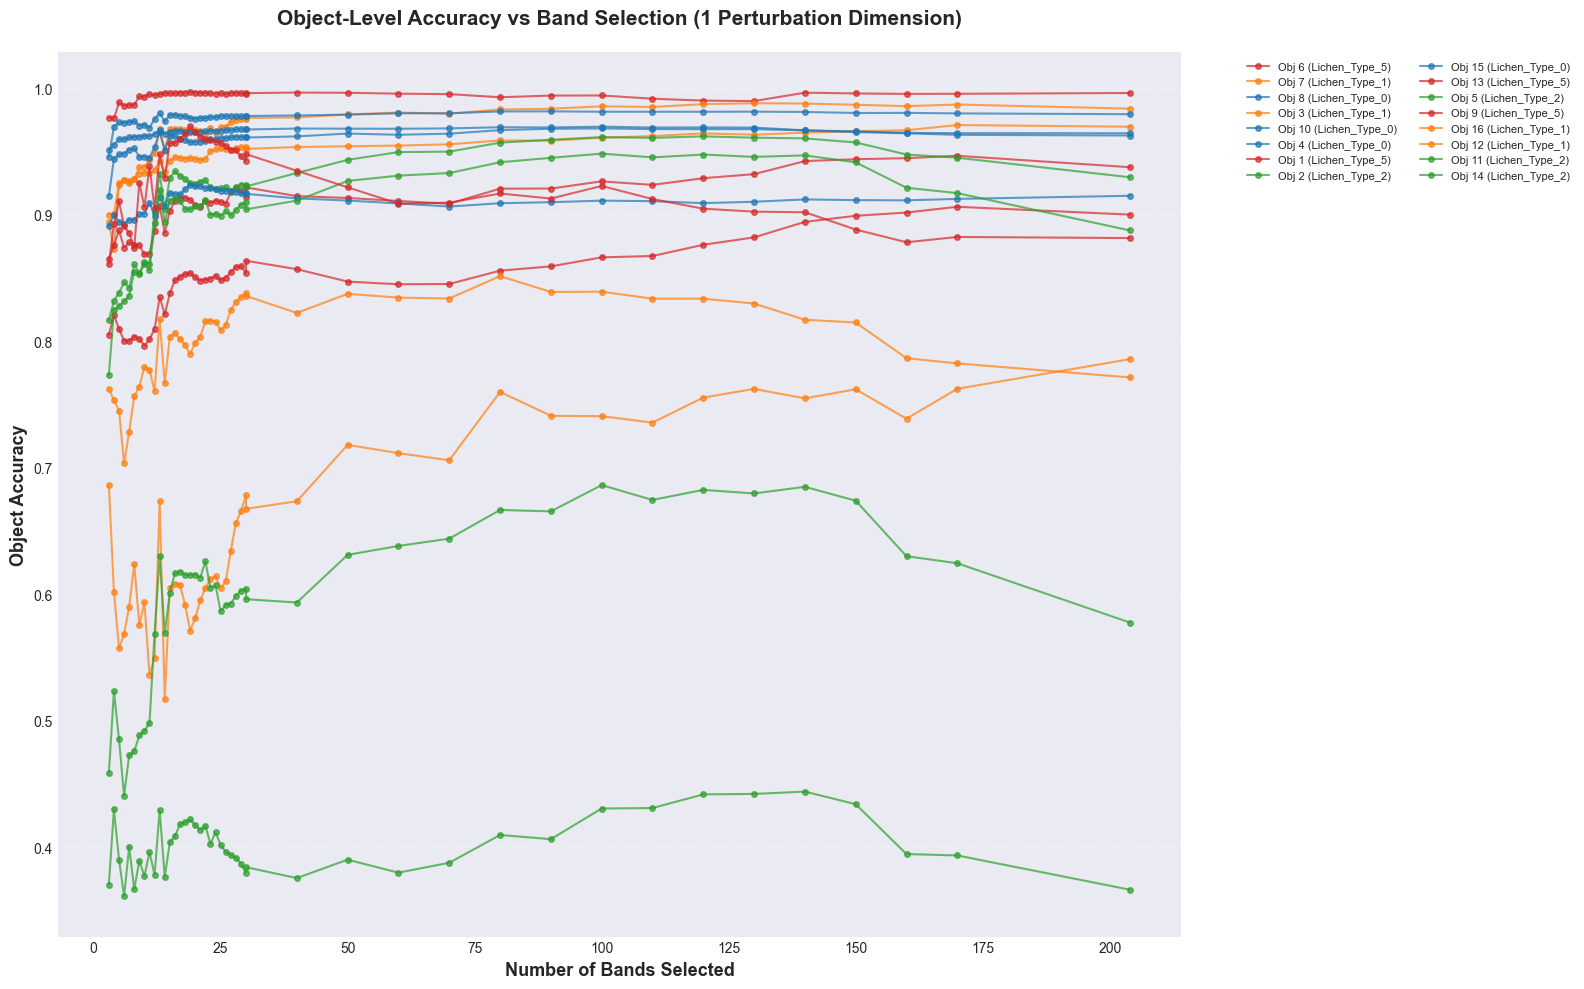

In [9]:
def plot_all_objects_accuracy(df: pd.DataFrame):
    """
    Plot accuracy vs bands for all objects in one figure.
    """
    fig, ax = plt.subplots(figsize=(16, 10))
    
    # Get unique objects sorted by baseline accuracy
    objects_sorted = df.groupby('object_id')['baseline_accuracy'].first().sort_values(ascending=False).index
    
    # Color map by class
    class_colors = {0: 'tab:blue', 1: 'tab:orange', 2: 'tab:green', 5: 'tab:red'}
    
    for obj_id in objects_sorted:
        obj_data = df[df['object_id'] == obj_id].sort_values('n_bands')
        obj_class = obj_data['true_class'].iloc[0]
        obj_class_name = obj_data['class_name'].iloc[0]
        
        ax.plot(obj_data['n_bands'], obj_data['accuracy'], 
               marker='o', linewidth=1.5, markersize=4, alpha=0.7,
               label=f'Obj {obj_id} ({obj_class_name})',
               color=class_colors[obj_class])
    
    ax.set_xlabel('Number of Bands Selected', fontsize=13, fontweight='bold')
    ax.set_ylabel('Object Accuracy', fontsize=13, fontweight='bold')
    ax.set_title('Object-Level Accuracy vs Band Selection (1 Perturbation Dimension)', 
                fontsize=15, fontweight='bold', pad=20)
    ax.grid(True, alpha=0.3, linestyle=':')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8, ncol=2)
    
    plt.tight_layout()
    plt.savefig(OUTPUT_PATH / 'summary' / 'all_objects_accuracy_vs_bands.png', dpi=300, bbox_inches='tight')
    plt.show()

plot_all_objects_accuracy(df)

### 3.2 Objects Grouped by Class

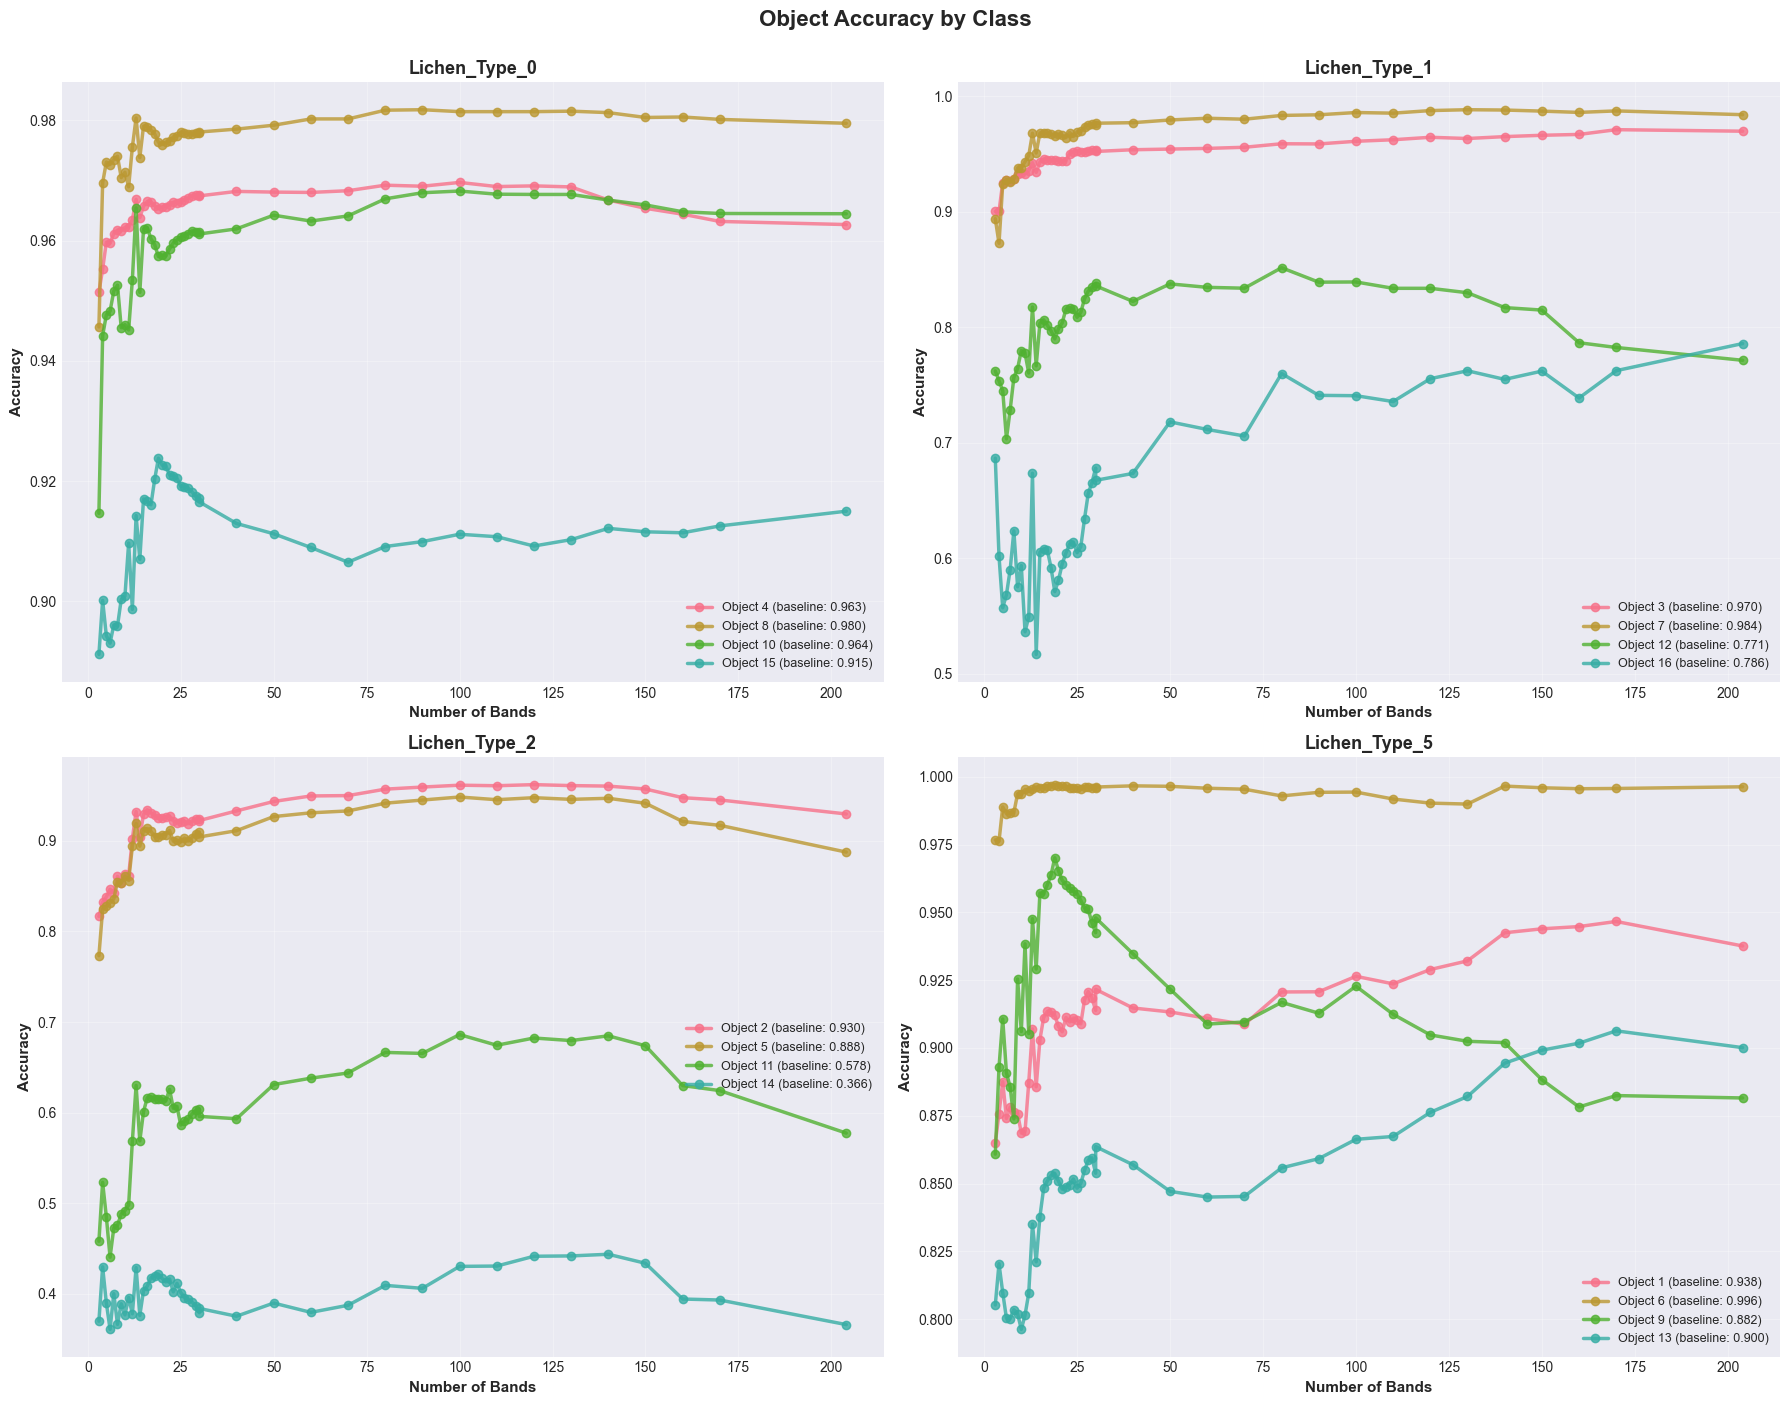

In [10]:
def plot_objects_by_class(df: pd.DataFrame):
    """
    Create separate subplots for each class.
    """
    classes = sorted(df['true_class'].unique())
    
    fig, axes = plt.subplots(2, 2, figsize=(18, 14))
    axes = axes.flatten()
    
    for idx, cls in enumerate(classes):
        ax = axes[idx]
        class_data = df[df['true_class'] == cls]
        objects_in_class = sorted(class_data['object_id'].unique())
        
        for obj_id in objects_in_class:
            obj_data = class_data[class_data['object_id'] == obj_id].sort_values('n_bands')
            baseline_acc = obj_data['baseline_accuracy'].iloc[0]
            
            ax.plot(obj_data['n_bands'], obj_data['accuracy'], 
                   marker='o', linewidth=2.5, markersize=6, alpha=0.8,
                   label=f'Object {obj_id} (baseline: {baseline_acc:.3f})')
        
        ax.set_xlabel('Number of Bands', fontsize=11, fontweight='bold')
        ax.set_ylabel('Accuracy', fontsize=11, fontweight='bold')
        ax.set_title(f'{CLASS_NAMES[cls]}', fontsize=13, fontweight='bold')
        ax.grid(True, alpha=0.3)
        ax.legend(fontsize=9, loc='best')
    
    plt.suptitle('Object Accuracy by Class', fontsize=16, fontweight='bold', y=1.00)
    plt.tight_layout()
    plt.savefig(OUTPUT_PATH / 'by_class' / 'objects_by_class.png', dpi=300, bbox_inches='tight')
    plt.show()

plot_objects_by_class(df)

### 3.3 Individual Object Plots (For Presentations)

In [11]:
def plot_individual_object(df: pd.DataFrame, obj_id: int, save_path: Path):
    """
    Create a detailed plot for a single object.
    """
    obj_data = df[df['object_id'] == obj_id].sort_values('n_bands')
    
    if len(obj_data) == 0:
        print(f"No data for object {obj_id}")
        return
    
    obj_class = obj_data['true_class'].iloc[0]
    obj_class_name = obj_data['class_name'].iloc[0]
    baseline_acc = obj_data['baseline_accuracy'].iloc[0]
    num_pixels = obj_data['num_pixels'].iloc[0]
    
    # Calculate statistics
    max_acc = obj_data['accuracy'].max()
    min_acc = obj_data['accuracy'].min()
    best_bands = obj_data.loc[obj_data['accuracy'].idxmax(), 'n_bands']
    improvement = max_acc - baseline_acc
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot 1: Accuracy vs bands
    ax1.plot(obj_data['n_bands'], obj_data['accuracy'], 
            marker='o', linewidth=2.5, markersize=8, color='steelblue', label='Accuracy')
    
    # Mark baseline
    ax1.axhline(y=baseline_acc, color='red', linestyle='--', linewidth=2, 
               label=f'Baseline: {baseline_acc:.4f}', alpha=0.7)
    
    # Mark best point
    ax1.scatter([best_bands], [max_acc], color='gold', s=300, marker='*', 
               edgecolor='black', linewidth=2, zorder=5, 
               label=f'Best: {max_acc:.4f} at {int(best_bands)} bands')
    
    ax1.set_xlabel('Number of Bands', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
    ax1.set_title(f'Object {obj_id}: {obj_class_name}\n({num_pixels:,} pixels)', 
                 fontsize=13, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    ax1.legend(fontsize=10, loc='best')
    
    # Add text box with stats
    stats_text = f"Baseline: {baseline_acc:.4f}\n"
    stats_text += f"Max: {max_acc:.4f}\n"
    stats_text += f"Min: {min_acc:.4f}\n"
    stats_text += f"Range: {max_acc - min_acc:.4f}\n"
    stats_text += f"Best improvement: {improvement:+.4f}"
    
    ax1.text(0.02, 0.98, stats_text, transform=ax1.transAxes,
            fontsize=9, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    # Plot 2: Difference from baseline
    ax2.plot(obj_data['n_bands'], obj_data['accuracy_diff_from_baseline'], 
            marker='s', linewidth=2.5, markersize=8, color='darkorange')
    ax2.axhline(y=0, color='red', linestyle='--', linewidth=2, alpha=0.7)
    
    # Fill areas
    ax2.fill_between(obj_data['n_bands'], 0, obj_data['accuracy_diff_from_baseline'],
                     where=(obj_data['accuracy_diff_from_baseline'] >= 0),
                     alpha=0.3, color='green', label='Better than baseline')
    ax2.fill_between(obj_data['n_bands'], 0, obj_data['accuracy_diff_from_baseline'],
                     where=(obj_data['accuracy_diff_from_baseline'] < 0),
                     alpha=0.3, color='red', label='Worse than baseline')
    
    ax2.set_xlabel('Number of Bands', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Accuracy Difference from Baseline', fontsize=12, fontweight='bold')
    ax2.set_title(f'Performance Relative to Baseline', fontsize=13, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    ax2.legend(fontsize=10, loc='best')
    
    plt.tight_layout()
    plt.savefig(save_path / f'object_{obj_id:02d}_{obj_class_name}_detailed.png', 
               dpi=300, bbox_inches='tight')
    plt.close()

# Generate individual plots for all objects
print("Generating individual object plots...")
for obj_id in sorted(df['object_id'].unique()):
    plot_individual_object(df, obj_id, OUTPUT_PATH / 'individual_objects')
    print(f"  Generated plot for Object {obj_id}")

print(f"\nAll individual plots saved to: {OUTPUT_PATH / 'individual_objects'}")

Generating individual object plots...
  Generated plot for Object 1
  Generated plot for Object 2
  Generated plot for Object 3
  Generated plot for Object 4
  Generated plot for Object 5
  Generated plot for Object 6
  Generated plot for Object 7
  Generated plot for Object 8
  Generated plot for Object 9
  Generated plot for Object 10
  Generated plot for Object 11
  Generated plot for Object 12
  Generated plot for Object 13
  Generated plot for Object 14
  Generated plot for Object 15
  Generated plot for Object 16

All individual plots saved to: C:\Users\meloy\PycharmProjects\Capstone\wavelength_analysis\perturbation_dimension_analysis\object_figures\individual_objects


## 4. Object Performance Heatmaps

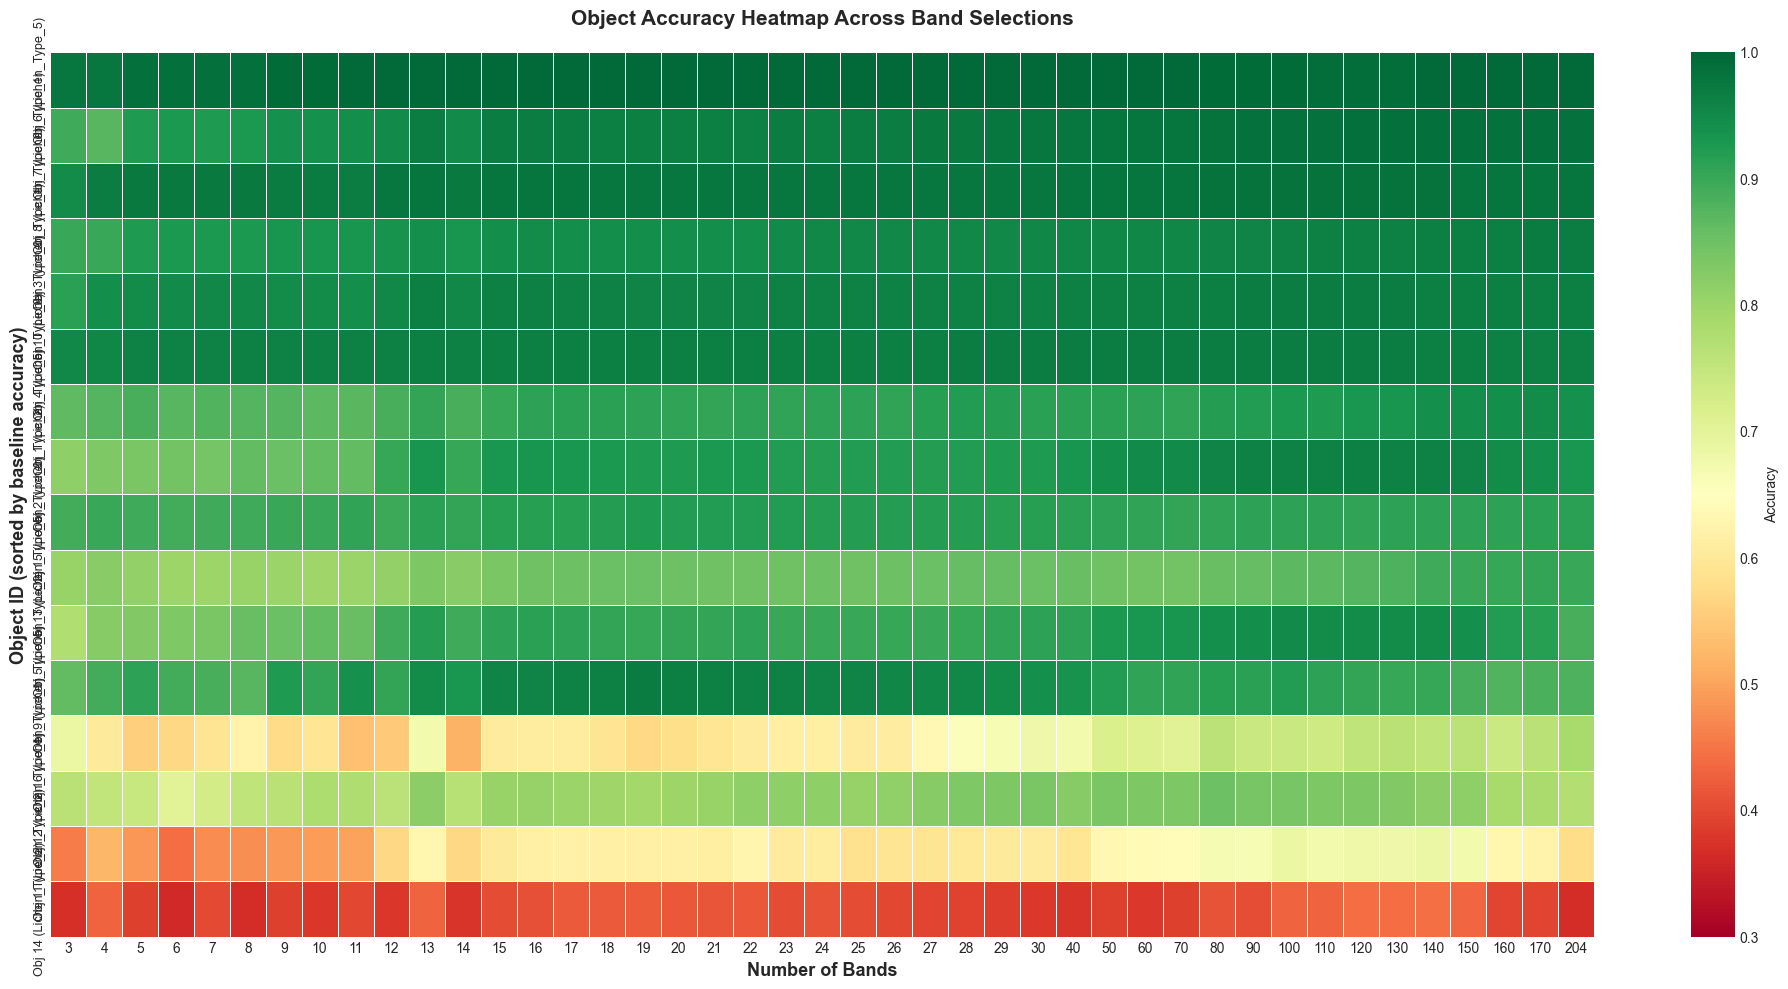

In [12]:
def plot_object_heatmap(df: pd.DataFrame):
    """
    Create a heatmap showing accuracy for all objects across all band selections.
    """
    # Pivot table: objects × n_bands
    pivot_data = df.pivot_table(
        values='accuracy',
        index='object_id',
        columns='n_bands',
        aggfunc='first'
    )
    
    # Sort by baseline accuracy
    baseline_order = df[df['config_name'] == 'BASELINE_FULL_DATA'].sort_values(
        'accuracy', ascending=False)['object_id'].values
    pivot_data = pivot_data.reindex(baseline_order)
    
    fig, ax = plt.subplots(figsize=(20, 10))
    
    sns.heatmap(pivot_data, annot=False, cmap='RdYlGn', vmin=0.3, vmax=1.0,
               cbar_kws={'label': 'Accuracy'}, ax=ax, linewidths=0.5)
    
    # Add class labels
    y_labels = [f"Obj {obj_id} ({CLASS_NAMES[df[df['object_id']==obj_id]['true_class'].iloc[0]]})" 
               for obj_id in pivot_data.index]
    ax.set_yticklabels(y_labels, fontsize=9)
    
    ax.set_xlabel('Number of Bands', fontsize=13, fontweight='bold')
    ax.set_ylabel('Object ID (sorted by baseline accuracy)', fontsize=13, fontweight='bold')
    ax.set_title('Object Accuracy Heatmap Across Band Selections', 
                fontsize=15, fontweight='bold', pad=20)
    
    plt.tight_layout()
    plt.savefig(OUTPUT_PATH / 'summary' / 'object_accuracy_heatmap.png', dpi=300, bbox_inches='tight')
    plt.show()

plot_object_heatmap(df)

## 5. Object Sensitivity Analysis

Analyze how sensitive each object is to band selection changes.

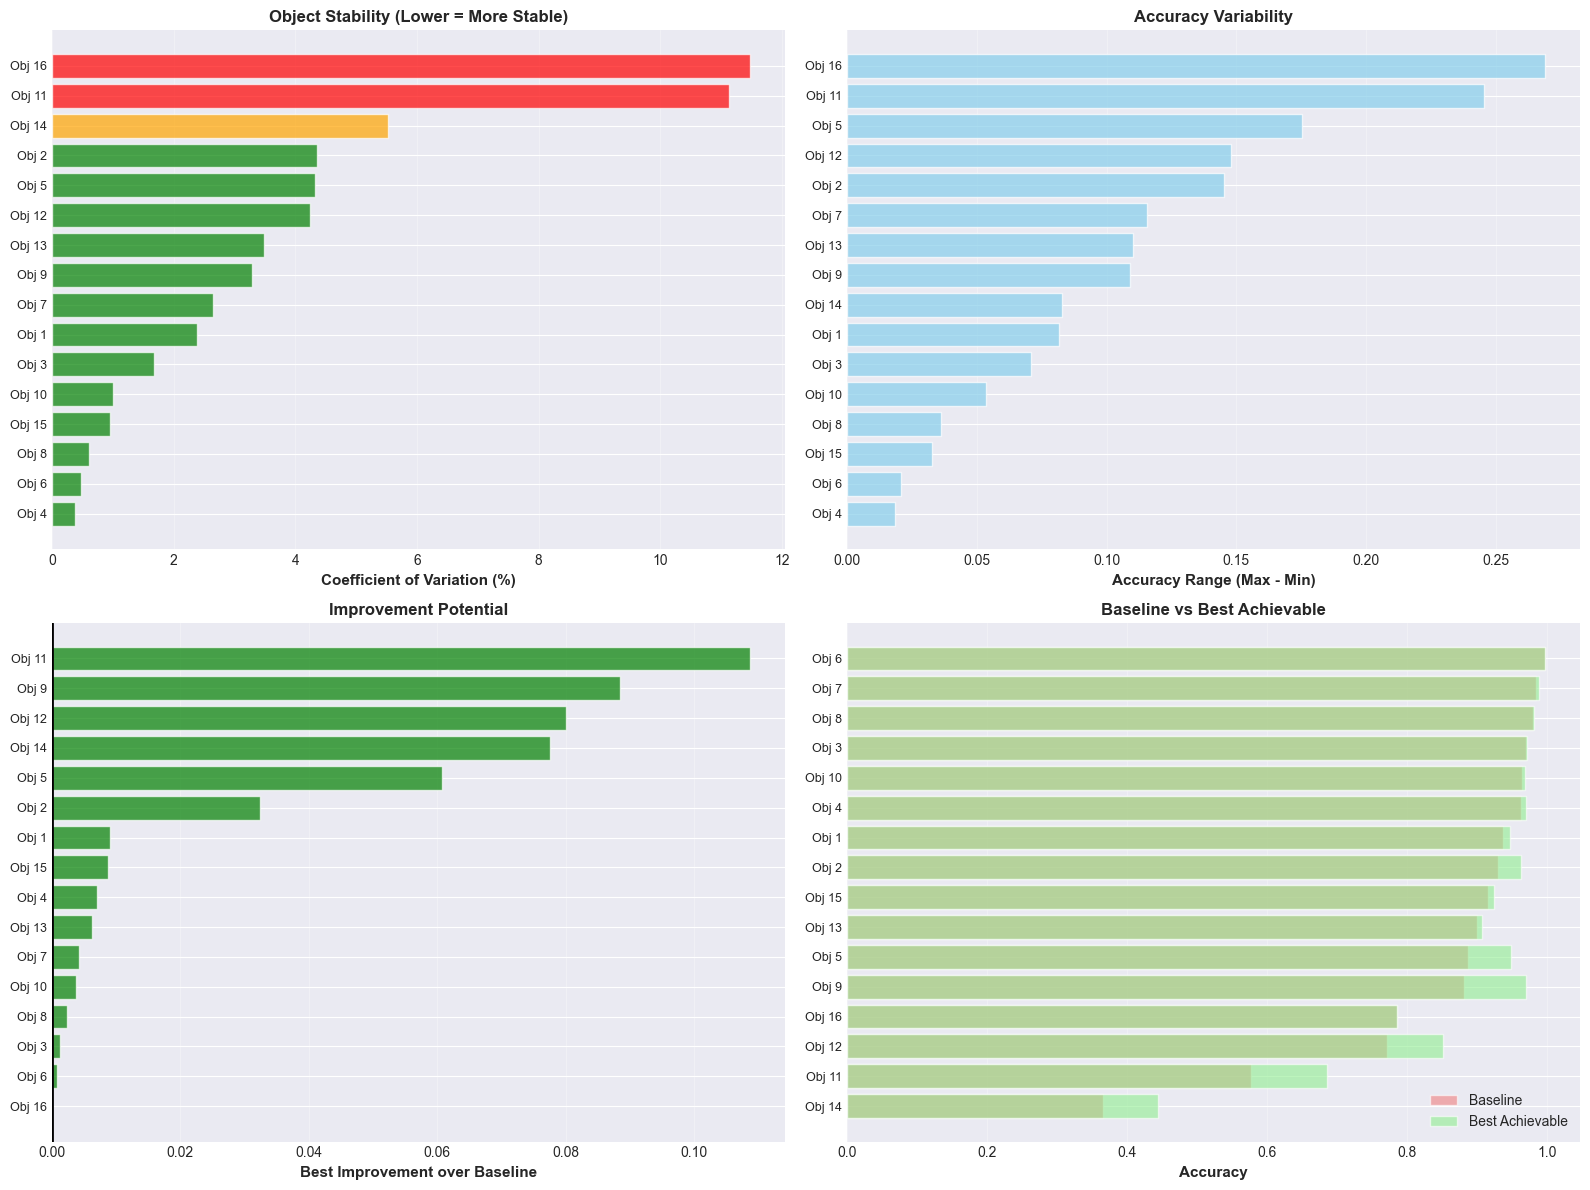

In [13]:
def plot_object_sensitivity(object_stats: pd.DataFrame):
    """
    Visualize object sensitivity to band selection.
    """
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Plot 1: Coefficient of Variation
    ax1 = axes[0, 0]
    sorted_by_cv = object_stats.sort_values('accuracy_cv')
    colors = ['green' if cv < 5 else 'orange' if cv < 10 else 'red' 
             for cv in sorted_by_cv['accuracy_cv']]
    
    bars = ax1.barh(range(len(sorted_by_cv)), sorted_by_cv['accuracy_cv'], color=colors, alpha=0.7)
    ax1.set_yticks(range(len(sorted_by_cv)))
    ax1.set_yticklabels([f"Obj {obj_id}" for obj_id in sorted_by_cv['object_id']], fontsize=9)
    ax1.set_xlabel('Coefficient of Variation (%)', fontsize=11, fontweight='bold')
    ax1.set_title('Object Stability (Lower = More Stable)', fontsize=12, fontweight='bold')
    ax1.grid(True, alpha=0.3, axis='x')
    
    # Plot 2: Accuracy Range
    ax2 = axes[0, 1]
    sorted_by_range = object_stats.sort_values('accuracy_range')
    ax2.barh(range(len(sorted_by_range)), sorted_by_range['accuracy_range'], 
            color='skyblue', alpha=0.7)
    ax2.set_yticks(range(len(sorted_by_range)))
    ax2.set_yticklabels([f"Obj {obj_id}" for obj_id in sorted_by_range['object_id']], fontsize=9)
    ax2.set_xlabel('Accuracy Range (Max - Min)', fontsize=11, fontweight='bold')
    ax2.set_title('Accuracy Variability', fontsize=12, fontweight='bold')
    ax2.grid(True, alpha=0.3, axis='x')
    
    # Plot 3: Best Improvement Potential
    ax3 = axes[1, 0]
    sorted_by_imp = object_stats.sort_values('best_improvement')
    colors_imp = ['green' if x > 0 else 'red' for x in sorted_by_imp['best_improvement']]
    ax3.barh(range(len(sorted_by_imp)), sorted_by_imp['best_improvement'], 
            color=colors_imp, alpha=0.7)
    ax3.set_yticks(range(len(sorted_by_imp)))
    ax3.set_yticklabels([f"Obj {obj_id}" for obj_id in sorted_by_imp['object_id']], fontsize=9)
    ax3.axvline(x=0, color='black', linestyle='-', linewidth=2)
    ax3.set_xlabel('Best Improvement over Baseline', fontsize=11, fontweight='bold')
    ax3.set_title('Improvement Potential', fontsize=12, fontweight='bold')
    ax3.grid(True, alpha=0.3, axis='x')
    
    # Plot 4: Baseline vs Best Achievable
    ax4 = axes[1, 1]
    sorted_by_baseline = object_stats.sort_values('baseline_accuracy')
    x_pos = range(len(sorted_by_baseline))
    
    ax4.barh(x_pos, sorted_by_baseline['baseline_accuracy'], 
            alpha=0.6, label='Baseline', color='lightcoral')
    ax4.barh(x_pos, sorted_by_baseline['accuracy_max'], 
            alpha=0.6, label='Best Achievable', color='lightgreen')
    
    ax4.set_yticks(x_pos)
    ax4.set_yticklabels([f"Obj {obj_id}" for obj_id in sorted_by_baseline['object_id']], fontsize=9)
    ax4.set_xlabel('Accuracy', fontsize=11, fontweight='bold')
    ax4.set_title('Baseline vs Best Achievable', fontsize=12, fontweight='bold')
    ax4.legend(fontsize=10)
    ax4.grid(True, alpha=0.3, axis='x')
    
    plt.tight_layout()
    plt.savefig(OUTPUT_PATH / 'summary' / 'object_sensitivity_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

plot_object_sensitivity(object_stats)

## 6. Class-Level Analysis

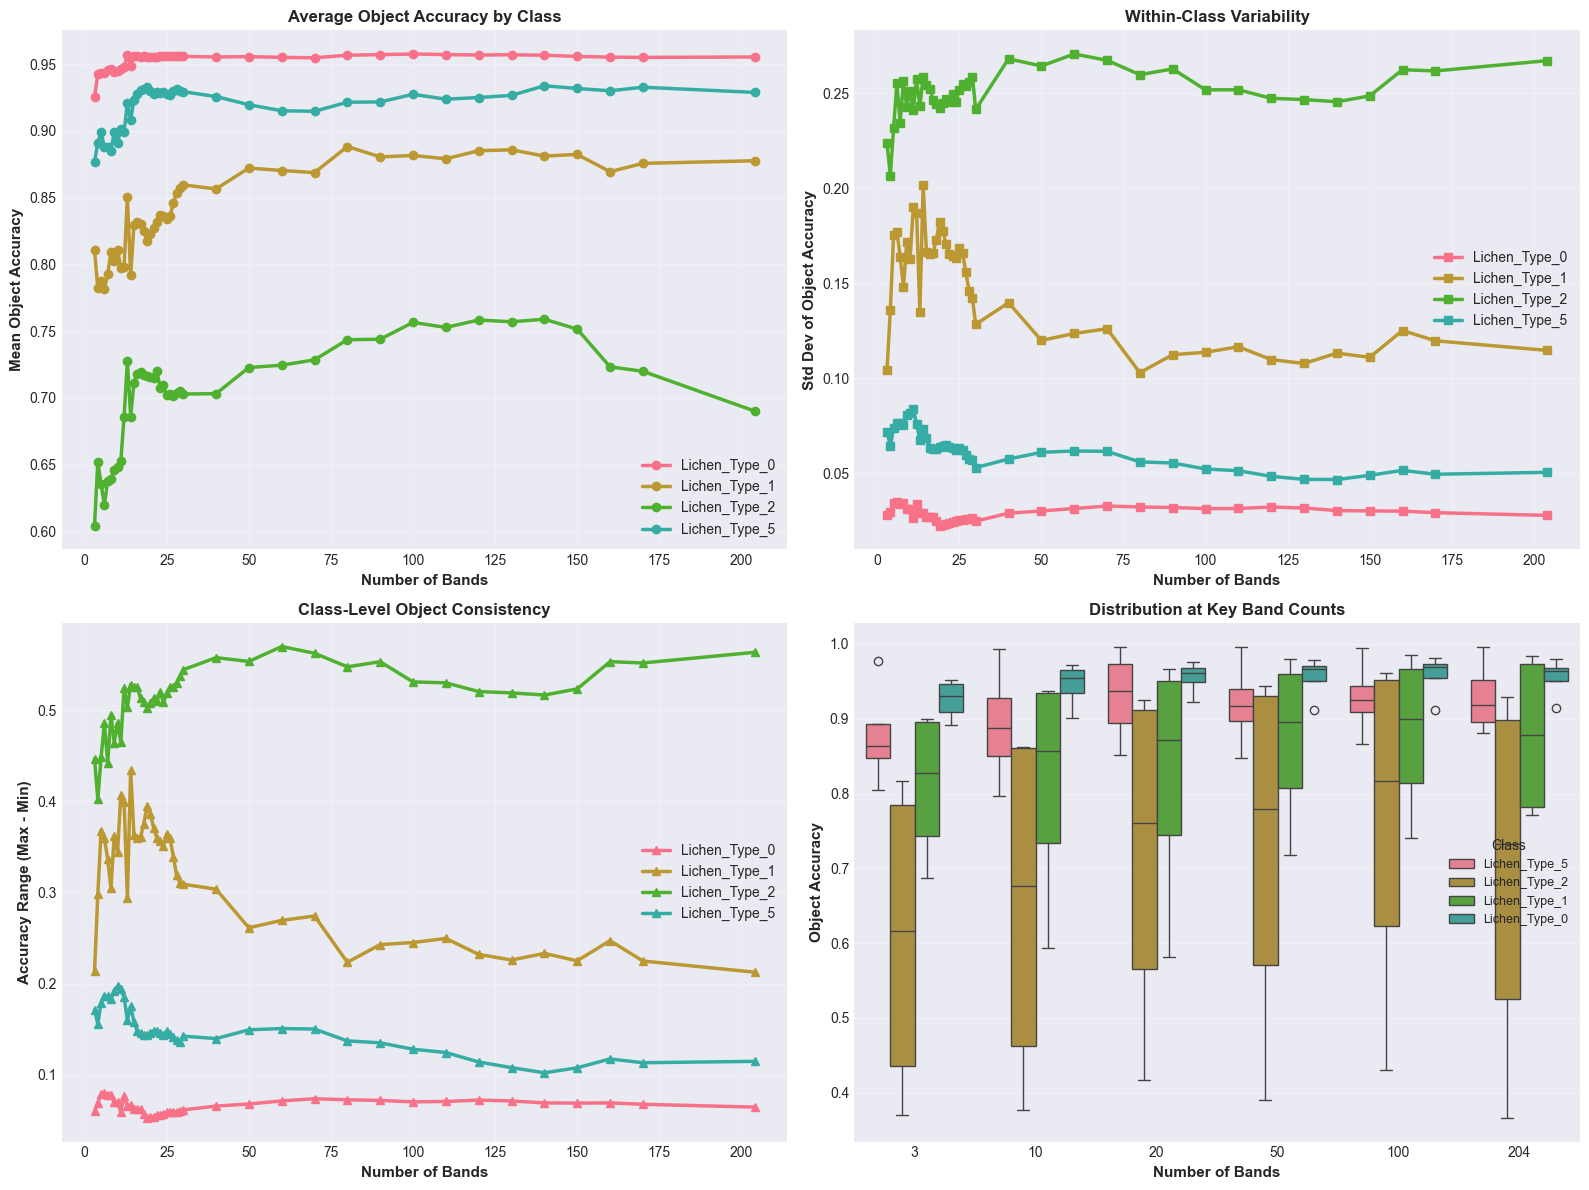


CLASS-LEVEL SUMMARY

Baseline (204 bands):
   class_name  mean_accuracy  std_accuracy  min_accuracy  max_accuracy
Lichen_Type_0       0.955413      0.027984      0.914994      0.979514
Lichen_Type_1       0.877679      0.114718      0.771354      0.983913
Lichen_Type_2       0.690247      0.267048      0.366239      0.929646
Lichen_Type_5       0.928892      0.050614      0.881566      0.996284


In [14]:
def plot_class_level_analysis(df: pd.DataFrame):
    """
    Analyze average performance by class.
    """
    # Calculate class-level statistics
    class_stats = df.groupby(['n_bands', 'true_class', 'class_name']).agg({
        'accuracy': ['mean', 'std', 'min', 'max']
    }).reset_index()
    
    class_stats.columns = ['n_bands', 'true_class', 'class_name', 
                           'mean_accuracy', 'std_accuracy', 'min_accuracy', 'max_accuracy']
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Plot 1: Mean accuracy by class
    ax1 = axes[0, 0]
    for cls in sorted(df['true_class'].unique()):
        cls_data = class_stats[class_stats['true_class'] == cls]
        ax1.plot(cls_data['n_bands'], cls_data['mean_accuracy'], 
                marker='o', linewidth=2.5, markersize=6, label=CLASS_NAMES[cls])
    
    ax1.set_xlabel('Number of Bands', fontsize=11, fontweight='bold')
    ax1.set_ylabel('Mean Object Accuracy', fontsize=11, fontweight='bold')
    ax1.set_title('Average Object Accuracy by Class', fontsize=12, fontweight='bold')
    ax1.legend(fontsize=10)
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Variability by class (std)
    ax2 = axes[0, 1]
    for cls in sorted(df['true_class'].unique()):
        cls_data = class_stats[class_stats['true_class'] == cls]
        ax2.plot(cls_data['n_bands'], cls_data['std_accuracy'], 
                marker='s', linewidth=2.5, markersize=6, label=CLASS_NAMES[cls])
    
    ax2.set_xlabel('Number of Bands', fontsize=11, fontweight='bold')
    ax2.set_ylabel('Std Dev of Object Accuracy', fontsize=11, fontweight='bold')
    ax2.set_title('Within-Class Variability', fontsize=12, fontweight='bold')
    ax2.legend(fontsize=10)
    ax2.grid(True, alpha=0.3)
    
    # Plot 3: Min-Max range by class
    ax3 = axes[1, 0]
    for cls in sorted(df['true_class'].unique()):
        cls_data = class_stats[class_stats['true_class'] == cls]
        range_acc = cls_data['max_accuracy'] - cls_data['min_accuracy']
        ax3.plot(cls_data['n_bands'], range_acc, 
                marker='^', linewidth=2.5, markersize=6, label=CLASS_NAMES[cls])
    
    ax3.set_xlabel('Number of Bands', fontsize=11, fontweight='bold')
    ax3.set_ylabel('Accuracy Range (Max - Min)', fontsize=11, fontweight='bold')
    ax3.set_title('Class-Level Object Consistency', fontsize=12, fontweight='bold')
    ax3.legend(fontsize=10)
    ax3.grid(True, alpha=0.3)
    
    # Plot 4: Box plots at key band counts
    ax4 = axes[1, 1]
    key_bands = [3, 10, 20, 50, 100, 204]
    
    # Filter data for key bands only
    df_key = df[df['n_bands'].isin(key_bands)]
    
    sns.boxplot(data=df_key, x='n_bands', y='accuracy', hue='class_name', ax=ax4)
    ax4.set_xlabel('Number of Bands', fontsize=11, fontweight='bold')
    ax4.set_ylabel('Object Accuracy', fontsize=11, fontweight='bold')
    ax4.set_title('Distribution at Key Band Counts', fontsize=12, fontweight='bold')
    ax4.legend(title='Class', fontsize=9, title_fontsize=10)
    ax4.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.savefig(OUTPUT_PATH / 'by_class' / 'class_level_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print class statistics
    print("\n" + "="*100)
    print("CLASS-LEVEL SUMMARY")
    print("="*100)
    
    baseline_class_stats = class_stats[class_stats['n_bands'] == 204]
    print("\nBaseline (204 bands):")
    print(baseline_class_stats[['class_name', 'mean_accuracy', 'std_accuracy', 'min_accuracy', 'max_accuracy']].to_string(index=False))

plot_class_level_analysis(df)

## 7. Optimal Band Selection Analysis

Find optimal band counts for each object.

In [15]:
# Find best configuration for each object
best_configs_per_object = []

for obj_id in sorted(df['object_id'].unique()):
    obj_data = df[df['object_id'] == obj_id]
    
    # Best overall
    best_idx = obj_data['accuracy'].idxmax()
    best_row = obj_data.loc[best_idx]
    
    # Best with minimal bands (within 1% of best)
    threshold = best_row['accuracy'] * 0.99
    within_threshold = obj_data[obj_data['accuracy'] >= threshold]
    min_bands_idx = within_threshold['n_bands'].idxmin()
    min_bands_row = within_threshold.loc[min_bands_idx]
    
    best_configs_per_object.append({
        'object_id': obj_id,
        'true_class': best_row['true_class'],
        'class_name': best_row['class_name'],
        'baseline_accuracy': best_row['baseline_accuracy'],
        'best_accuracy': best_row['accuracy'],
        'best_n_bands': best_row['n_bands'],
        'improvement': best_row['accuracy'] - best_row['baseline_accuracy'],
        'efficient_accuracy': min_bands_row['accuracy'],
        'efficient_n_bands': min_bands_row['n_bands'],
        'band_reduction_pct': (1 - min_bands_row['n_bands'] / 204) * 100
    })

best_configs_df = pd.DataFrame(best_configs_per_object)

print("\n" + "="*100)
print("OPTIMAL BAND SELECTION PER OBJECT")
print("="*100)
print("\nBest achievable accuracy for each object:")
print(best_configs_df.to_string(index=False))

print("\n" + "="*100)
print("SUMMARY STATISTICS")
print("="*100)
print(f"\nAverage best accuracy: {best_configs_df['best_accuracy'].mean():.4f}")
print(f"Average baseline accuracy: {best_configs_df['baseline_accuracy'].mean():.4f}")
print(f"Average improvement: {best_configs_df['improvement'].mean():.4f}")
print(f"\nAverage optimal bands: {best_configs_df['best_n_bands'].mean():.1f}")
print(f"Average efficient bands (99% of best): {best_configs_df['efficient_n_bands'].mean():.1f}")
print(f"Average band reduction: {best_configs_df['band_reduction_pct'].mean():.1f}%")


OPTIMAL BAND SELECTION PER OBJECT

Best achievable accuracy for each object:
 object_id  true_class    class_name  baseline_accuracy  best_accuracy  best_n_bands  improvement  efficient_accuracy  efficient_n_bands  band_reduction_pct
         1           5 Lichen_Type_5           0.937600       0.946633           170     0.009033            0.942464                140           31.372549
         2           2 Lichen_Type_2           0.929646       0.962005           120     0.032359            0.957023                 80           60.784314
         3           1 Lichen_Type_1           0.969622       0.970939           170     0.001317            0.962213                110           46.078431
         4           0 Lichen_Type_0           0.962672       0.969678           100     0.007006            0.961178                  7           96.568627
         5           2 Lichen_Type_2           0.887586       0.948356           100     0.060770            0.941530                 80 

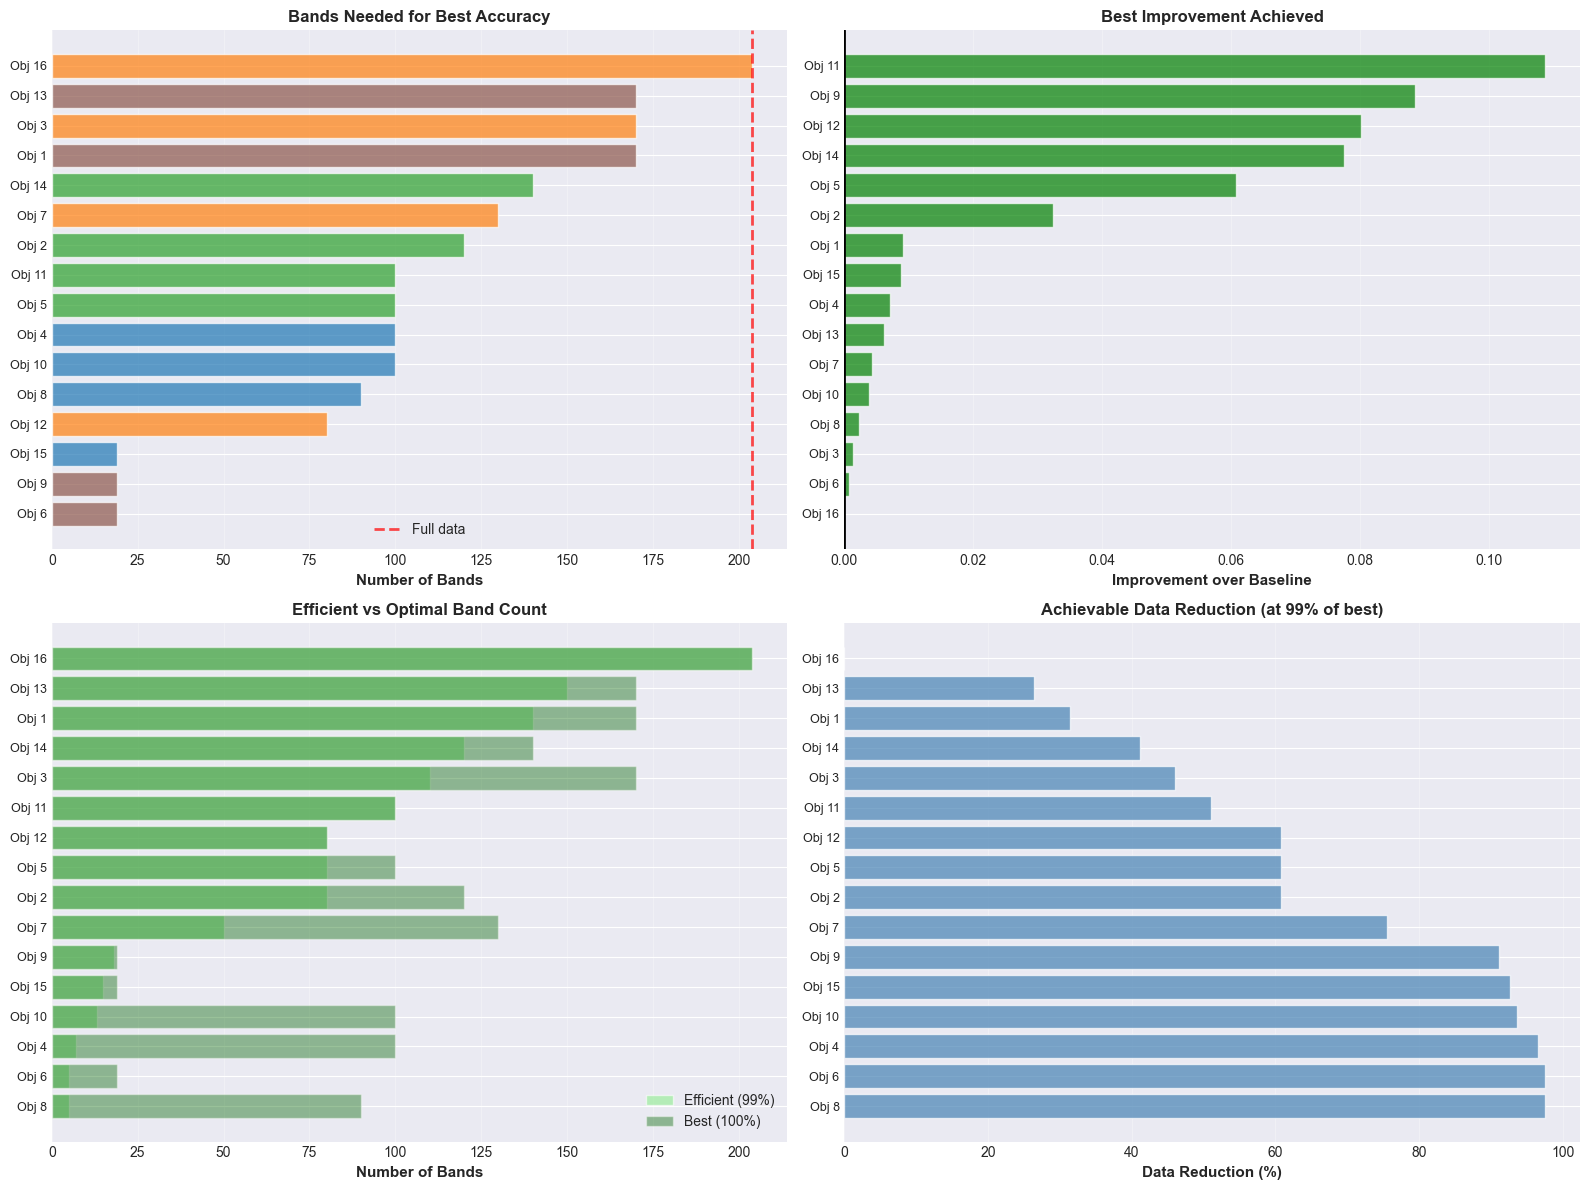

In [16]:
def plot_optimal_bands_analysis(best_configs_df: pd.DataFrame):
    """
    Visualize optimal band selection results.
    """
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Plot 1: Best bands needed per object
    ax1 = axes[0, 0]
    sorted_df = best_configs_df.sort_values('best_n_bands')
    colors_class = [plt.cm.tab10(cls) for cls in sorted_df['true_class']]
    
    bars = ax1.barh(range(len(sorted_df)), sorted_df['best_n_bands'], color=colors_class, alpha=0.7)
    ax1.set_yticks(range(len(sorted_df)))
    ax1.set_yticklabels([f"Obj {obj_id}" for obj_id in sorted_df['object_id']], fontsize=9)
    ax1.axvline(x=204, color='red', linestyle='--', linewidth=2, label='Full data', alpha=0.7)
    ax1.set_xlabel('Number of Bands', fontsize=11, fontweight='bold')
    ax1.set_title('Bands Needed for Best Accuracy', fontsize=12, fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3, axis='x')
    
    # Plot 2: Improvement achieved
    ax2 = axes[0, 1]
    sorted_by_imp = best_configs_df.sort_values('improvement')
    colors_imp = ['green' if x >= 0 else 'red' for x in sorted_by_imp['improvement']]
    
    ax2.barh(range(len(sorted_by_imp)), sorted_by_imp['improvement'], 
            color=colors_imp, alpha=0.7)
    ax2.set_yticks(range(len(sorted_by_imp)))
    ax2.set_yticklabels([f"Obj {obj_id}" for obj_id in sorted_by_imp['object_id']], fontsize=9)
    ax2.axvline(x=0, color='black', linestyle='-', linewidth=2)
    ax2.set_xlabel('Improvement over Baseline', fontsize=11, fontweight='bold')
    ax2.set_title('Best Improvement Achieved', fontsize=12, fontweight='bold')
    ax2.grid(True, alpha=0.3, axis='x')
    
    # Plot 3: Efficient bands (99% of best)
    ax3 = axes[1, 0]
    sorted_eff = best_configs_df.sort_values('efficient_n_bands')
    
    x_pos = range(len(sorted_eff))
    ax3.barh(x_pos, sorted_eff['efficient_n_bands'], alpha=0.6, 
            label='Efficient (99%)', color='lightgreen')
    ax3.barh(x_pos, sorted_eff['best_n_bands'], alpha=0.4, 
            label='Best (100%)', color='darkgreen')
    
    ax3.set_yticks(x_pos)
    ax3.set_yticklabels([f"Obj {obj_id}" for obj_id in sorted_eff['object_id']], fontsize=9)
    ax3.set_xlabel('Number of Bands', fontsize=11, fontweight='bold')
    ax3.set_title('Efficient vs Optimal Band Count', fontsize=12, fontweight='bold')
    ax3.legend(fontsize=10)
    ax3.grid(True, alpha=0.3, axis='x')
    
    # Plot 4: Band reduction achieved
    ax4 = axes[1, 1]
    sorted_red = best_configs_df.sort_values('band_reduction_pct', ascending=False)
    
    ax4.barh(range(len(sorted_red)), sorted_red['band_reduction_pct'], 
            color='steelblue', alpha=0.7)
    ax4.set_yticks(range(len(sorted_red)))
    ax4.set_yticklabels([f"Obj {obj_id}" for obj_id in sorted_red['object_id']], fontsize=9)
    ax4.set_xlabel('Data Reduction (%)', fontsize=11, fontweight='bold')
    ax4.set_title('Achievable Data Reduction (at 99% of best)', fontsize=12, fontweight='bold')
    ax4.grid(True, alpha=0.3, axis='x')
    
    plt.tight_layout()
    plt.savefig(OUTPUT_PATH / 'summary' / 'optimal_bands_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

plot_optimal_bands_analysis(best_configs_df)

## 8. Object Clustering by Performance Pattern

Group objects with similar performance patterns.

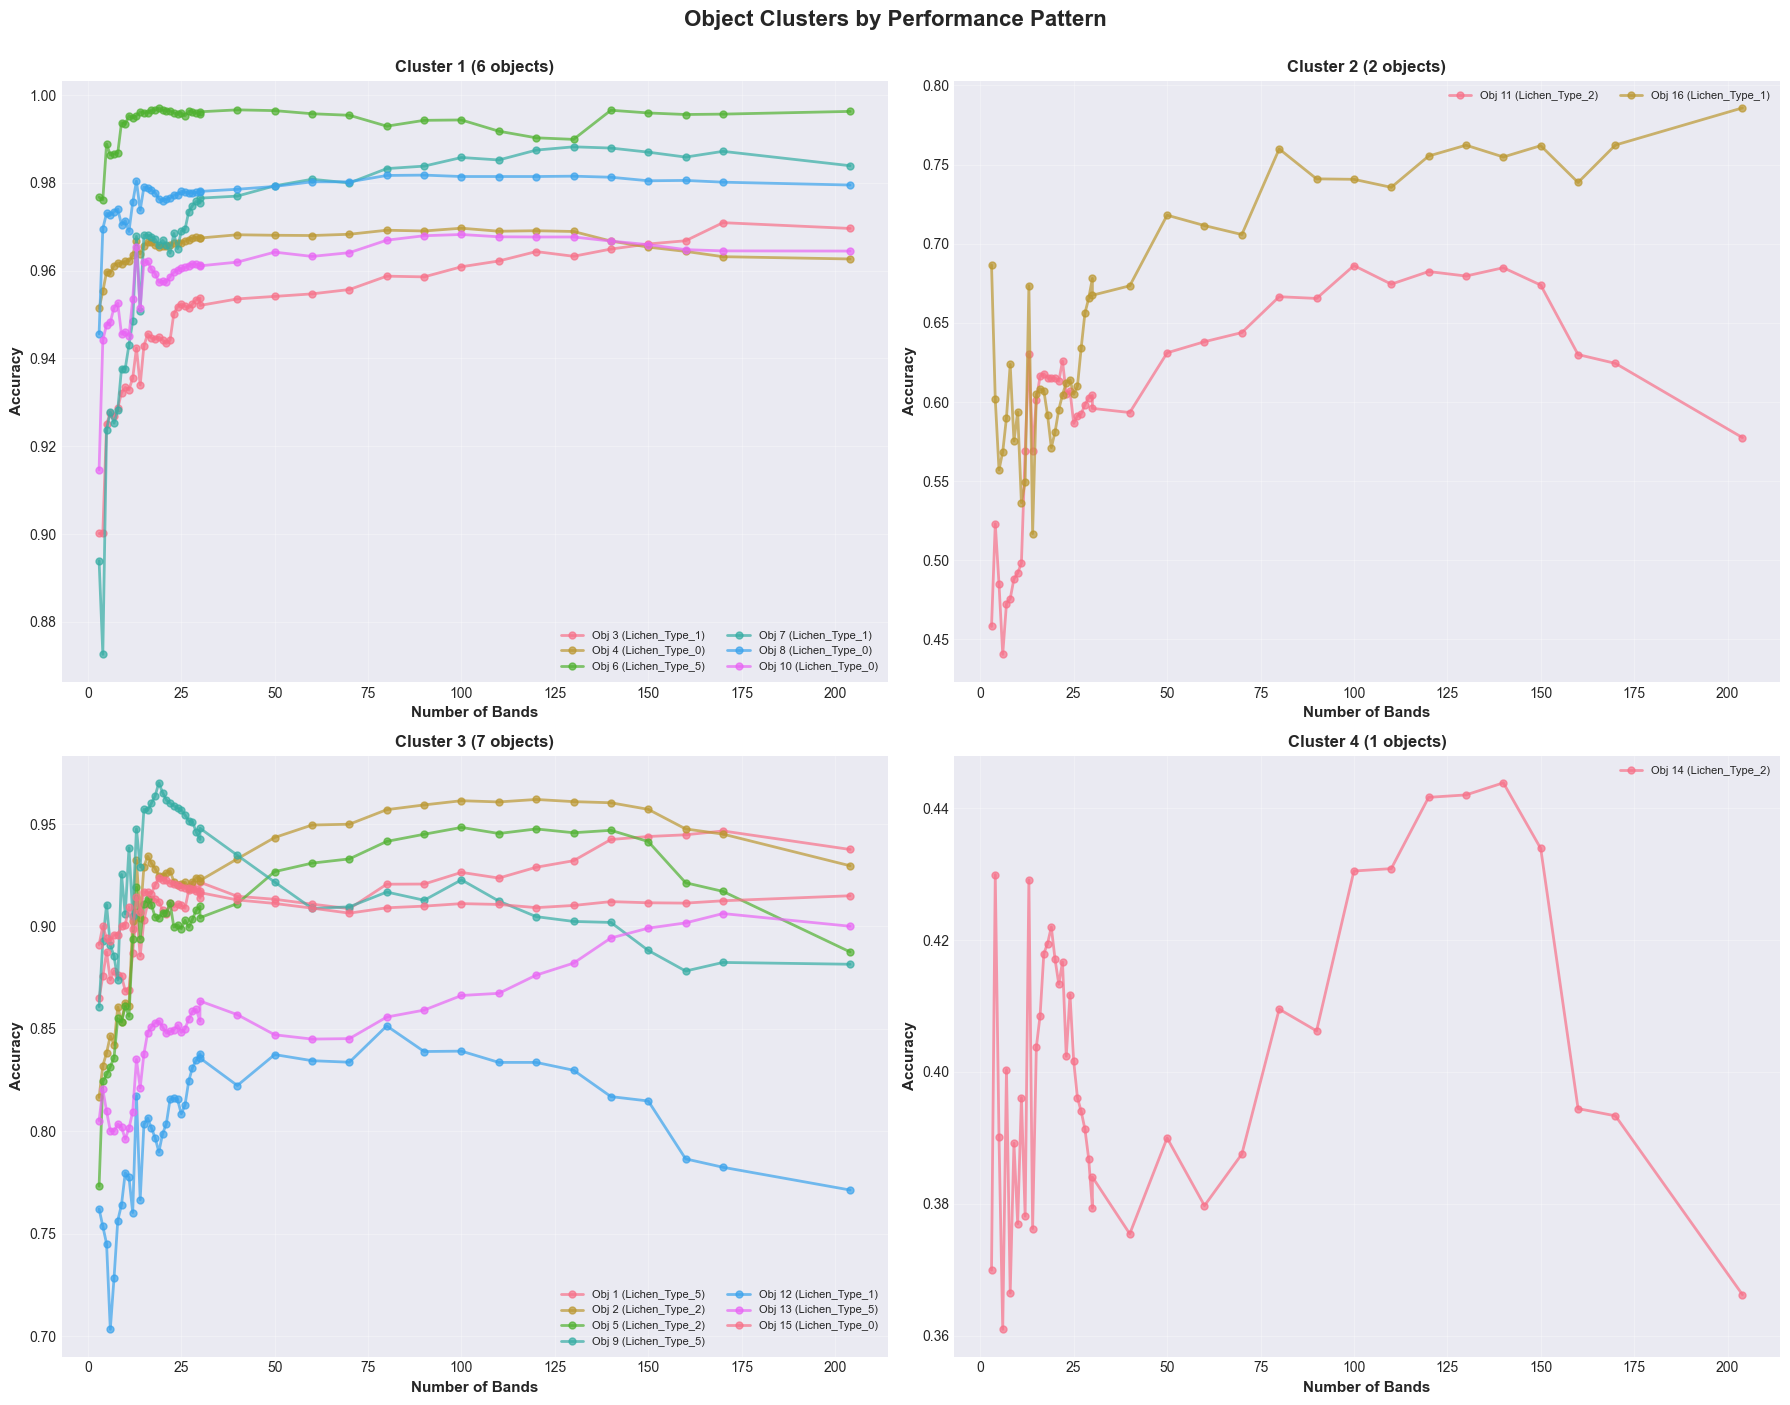


OBJECT CLUSTERS BY PERFORMANCE PATTERN

Cluster 1:
  Objects: [3, 4, 6, 7, 8, 10]
  Avg baseline accuracy: 0.9761
  Avg best accuracy: 0.9793
  Classes: ['Lichen_Type_1', 'Lichen_Type_0', 'Lichen_Type_5']

Cluster 2:
  Objects: [11, 16]
  Avg baseline accuracy: 0.6817
  Avg best accuracy: 0.7360
  Classes: ['Lichen_Type_2', 'Lichen_Type_1']

Cluster 3:
  Objects: [1, 2, 5, 9, 12, 13, 15]
  Avg baseline accuracy: 0.8890
  Avg best accuracy: 0.9298
  Classes: ['Lichen_Type_5', 'Lichen_Type_2', 'Lichen_Type_1', 'Lichen_Type_0']

Cluster 4:
  Objects: [14]
  Avg baseline accuracy: 0.3662
  Avg best accuracy: 0.4438
  Classes: ['Lichen_Type_2']


In [18]:
def cluster_objects_by_pattern(df: pd.DataFrame, n_clusters: int = 4):
    """
    Cluster objects based on their accuracy patterns across band selections.
    """
    # Create feature matrix: each row is an object, each column is accuracy at a specific band count
    pivot_data = df.pivot_table(
        values='accuracy',
        index='object_id',
        columns='n_bands',
        aggfunc='first'
    ).fillna(0)
    
    # Normalize
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(pivot_data.values)
    
    # K-means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(X_scaled)
    
    # Add cluster labels
    cluster_mapping = pd.DataFrame({
        'object_id': pivot_data.index,
        'cluster': clusters
    })
    
    df_clustered = df.merge(cluster_mapping, on='object_id')
    
    # Plot clusters
    fig, axes = plt.subplots(2, 2, figsize=(18, 14))
    axes = axes.flatten()
    
    for cluster_id in range(n_clusters):
        ax = axes[cluster_id]
        cluster_data = df_clustered[df_clustered['cluster'] == cluster_id]
        objects_in_cluster = sorted(cluster_data['object_id'].unique())
        
        for obj_id in objects_in_cluster:
            obj_data = cluster_data[cluster_data['object_id'] == obj_id].sort_values('n_bands')
            obj_class_name = obj_data['class_name'].iloc[0]
            
            ax.plot(obj_data['n_bands'], obj_data['accuracy'], 
                   marker='o', linewidth=2, markersize=5, alpha=0.7,
                   label=f'Obj {obj_id} ({obj_class_name})')
        
        ax.set_xlabel('Number of Bands', fontsize=11, fontweight='bold')
        ax.set_ylabel('Accuracy', fontsize=11, fontweight='bold')
        ax.set_title(f'Cluster {cluster_id + 1} ({len(objects_in_cluster)} objects)', 
                    fontsize=12, fontweight='bold')
        ax.legend(fontsize=8, loc='best', ncol=2)
        ax.grid(True, alpha=0.3)
    
    plt.suptitle('Object Clusters by Performance Pattern', fontsize=16, fontweight='bold', y=1.00)
    plt.tight_layout()
    plt.savefig(OUTPUT_PATH / 'summary' / 'object_clusters.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print cluster characteristics
    print("\n" + "="*100)
    print("OBJECT CLUSTERS BY PERFORMANCE PATTERN")
    print("="*100)
    
    for cluster_id in range(n_clusters):
        cluster_objs = cluster_mapping[cluster_mapping['cluster'] == cluster_id]['object_id'].tolist()
        cluster_data = df_clustered[df_clustered['cluster'] == cluster_id]
        
        print(f"\nCluster {cluster_id + 1}:")
        print(f"  Objects: {cluster_objs}")
        print(f"  Avg baseline accuracy: {cluster_data[cluster_data['n_bands']==204]['accuracy'].mean():.4f}")
        print(f"  Avg best accuracy: {cluster_data.groupby('object_id')['accuracy'].max().mean():.4f}")
        print(f"  Classes: {cluster_data['class_name'].unique().tolist()}")
    
    return df_clustered, cluster_mapping

df_clustered, cluster_mapping = cluster_objects_by_pattern(df, n_clusters=4)

## 9. Summary and Key Insights

In [19]:
print("\n" + "="*100)
print("COMPREHENSIVE OBJECT-LEVEL ANALYSIS SUMMARY")
print("="*100)

print("\n1. DATASET OVERVIEW")
print(f"   - Total objects analyzed: {df['object_id'].nunique()}")
print(f"   - Total configurations tested: {df['config_name'].nunique()}")
print(f"   - Band count range: {df['n_bands'].min()} to {df['n_bands'].max()} bands")
print(f"   - Classes: {len(df['true_class'].unique())}")

print("\n2. OVERALL PERFORMANCE")
baseline_mean = df[df['n_bands'] == 204]['accuracy'].mean()
best_mean = df.groupby('object_id')['accuracy'].max().mean()
print(f"   - Average baseline accuracy (204 bands): {baseline_mean:.4f}")
print(f"   - Average best achievable accuracy: {best_mean:.4f}")
print(f"   - Average improvement: {(best_mean - baseline_mean):.4f} ({((best_mean - baseline_mean)/baseline_mean)*100:+.2f}%)")

print("\n3. STABILITY")
most_stable_obj = object_stats.nsmallest(1, 'accuracy_cv').iloc[0]
least_stable_obj = object_stats.nlargest(1, 'accuracy_cv').iloc[0]
print(f"   - Most stable: Object {int(most_stable_obj['object_id'])} (CV: {most_stable_obj['accuracy_cv']:.2f}%)")
print(f"   - Least stable: Object {int(least_stable_obj['object_id'])} (CV: {least_stable_obj['accuracy_cv']:.2f}%)")
print(f"   - Average CV across all objects: {object_stats['accuracy_cv'].mean():.2f}%")

print("\n4. EFFICIENCY")
avg_optimal_bands = best_configs_df['best_n_bands'].mean()
avg_efficient_bands = best_configs_df['efficient_n_bands'].mean()
avg_reduction = best_configs_df['band_reduction_pct'].mean()
print(f"   - Average optimal bands for best accuracy: {avg_optimal_bands:.1f}")
print(f"   - Average efficient bands (99% of best): {avg_efficient_bands:.1f}")
print(f"   - Average achievable data reduction: {avg_reduction:.1f}%")

print("\n5. CLASS-LEVEL INSIGHTS")
for cls in sorted(df['true_class'].unique()):
    cls_baseline = df[(df['n_bands'] == 204) & (df['true_class'] == cls)]['accuracy'].mean()
    cls_best = df[df['true_class'] == cls].groupby('object_id')['accuracy'].max().mean()
    print(f"   - {CLASS_NAMES[cls]}:")
    print(f"     Baseline: {cls_baseline:.4f}, Best: {cls_best:.4f}, Improvement: {(cls_best - cls_baseline):+.4f}")

print("\n6. KEY RECOMMENDATIONS")
print(f"   - Focus on objects with high variability for targeted improvement")
print(f"   - Objects {object_stats.nsmallest(3, 'baseline_accuracy')['object_id'].tolist()} have lowest baseline - highest improvement potential")
print(f"   - Objects {object_stats.nlargest(3, 'accuracy_cv')['object_id'].tolist()} show high sensitivity - investigate why")
print(f"   - On average, using {avg_efficient_bands:.0f} bands achieves 99% of best accuracy with {avg_reduction:.0f}% data reduction")

print("\n" + "="*100)
print("All visualizations saved to:")
print(f"  - Summary plots: {OUTPUT_PATH / 'summary'}")
print(f"  - Individual object plots: {OUTPUT_PATH / 'individual_objects'}")
print(f"  - Class-based plots: {OUTPUT_PATH / 'by_class'}")
print("="*100)


COMPREHENSIVE OBJECT-LEVEL ANALYSIS SUMMARY

1. DATASET OVERVIEW
   - Total objects analyzed: 16
   - Total configurations tested: 43
   - Band count range: 3 to 204 bands
   - Classes: 4

2. OVERALL PERFORMANCE
   - Average baseline accuracy (204 bands): 0.8631
   - Average best achievable accuracy: 0.8938
   - Average improvement: 0.0307 (+3.56%)

3. STABILITY
   - Most stable: Object 4 (CV: 0.38%)
   - Least stable: Object 16 (CV: 11.47%)
   - Average CV across all objects: 3.62%

4. EFFICIENCY
   - Average optimal bands for best accuracy: 108.2
   - Average efficient bands (99% of best): 73.6
   - Average achievable data reduction: 63.9%

5. CLASS-LEVEL INSIGHTS
   - Lichen_Type_0:
     Baseline: 0.9554, Best: 0.9609, Improvement: +0.0055
   - Lichen_Type_1:
     Baseline: 0.8777, Best: 0.8991, Improvement: +0.0214
   - Lichen_Type_2:
     Baseline: 0.6902, Best: 0.7601, Improvement: +0.0699
   - Lichen_Type_5:
     Baseline: 0.9289, Best: 0.9550, Improvement: +0.0261

6. KEY RECO

## 10. Export Summary Statistics

In [20]:
# Export summary to CSV for easy reference
object_stats.to_csv(OUTPUT_PATH / 'object_statistics_summary.csv', index=False)
best_configs_df.to_csv(OUTPUT_PATH / 'optimal_configurations_per_object.csv', index=False)
cluster_mapping.to_csv(OUTPUT_PATH / 'object_clusters.csv', index=False)

print("Summary files exported:")
print(f"  - {OUTPUT_PATH / 'object_statistics_summary.csv'}")
print(f"  - {OUTPUT_PATH / 'optimal_configurations_per_object.csv'}")
print(f"  - {OUTPUT_PATH / 'object_clusters.csv'}")

Summary files exported:
  - C:\Users\meloy\PycharmProjects\Capstone\wavelength_analysis\perturbation_dimension_analysis\object_figures\object_statistics_summary.csv
  - C:\Users\meloy\PycharmProjects\Capstone\wavelength_analysis\perturbation_dimension_analysis\object_figures\optimal_configurations_per_object.csv
  - C:\Users\meloy\PycharmProjects\Capstone\wavelength_analysis\perturbation_dimension_analysis\object_figures\object_clusters.csv
